In [13]:
#Runs successfully on MBP 2024 metal_102 conda environment.
import numpy as np
import torch
import torch.nn as nn
import pymc as pm
from pytensor.compile.ops import as_op
import arviz as az
import pytensor.tensor as pt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Suppress PyTorch warnings
import os
import time

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Use CPU instead of GPU

In [14]:
# Define constants
SIZE = 10
T=100  #DANGER DANGER T and dt get redefined during execution!!!
dt=1
NUM_SAMPLES = SIZE
EPOCHS = 10

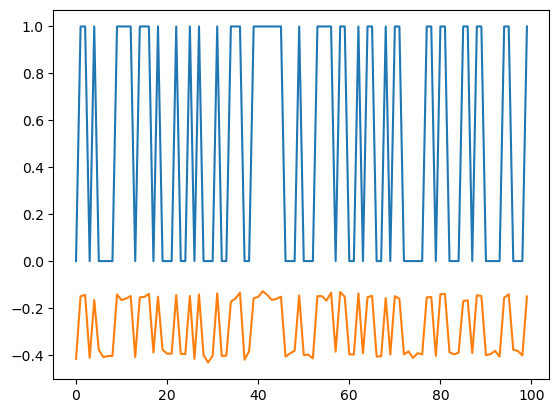

In [15]:
def sim_channel(params, T, dt):
    # kc12, kc21, spikeMax, Fnoise, scale, offset, nSpikes, kco1, koc2, ko12, ko21
    kc12, kc21, Fnoise, scale, offset,  kco1, koc2, ko12, ko21 = params
    
    t = torch.arange(0, T, dt)
    zero = torch.tensor(0.0)
    
    # Convert parameters to tensors
    kc12 = torch.tensor(kc12)
    kc21 = torch.tensor(kc21)
    kco1 = torch.tensor(kco1)
    koc2 = torch.tensor(koc2)
    ko12 = torch.tensor(ko12)
    ko21 = torch.tensor(ko21)
    Fnoise = torch.tensor(Fnoise)
    """
    nSpikes = torch.tensor(nSpikes, dtype=torch.int32)
    spikeMax = torch.tensor(spikeMax)"""
    scale = torch.tensor(scale)

    row1 = torch.stack([zero, kc12, zero, zero])
    row2 = torch.stack([kc21, zero, kco1, zero])
    row3 = torch.stack([zero, koc2, zero, ko12])
    row4 = torch.stack([zero,zero,ko21,zero])
    
    
    r1 = torch.sum(row1)
    #row1 = torch.stack([1-r1, kc12, zero, zero])
    r2 = torch.sum(row2)
    #row2 = torch.stack([kc21, 1-r2, kco1, zero])
    r3 = torch.sum(row3)
    #row3 = torch.stack([zero, koc2, 1-r3, ko12])
    r4 = torch.sum(row4)
    #row4 = torch.stack([zero, zero, ko21, 1-r4])

    def softmax_row(row):
        return torch.nn.functional.softmax(row, dim=0)
    
    row1 = softmax_row(torch.stack([1-r1, kc12, zero, zero]))
    row2 = softmax_row(torch.stack([kc21, 1-r2, kco1, zero]))
    row3 = softmax_row(torch.stack([zero, koc2, 1-r3, ko12]))
    row4 = softmax_row(torch.stack([zero, zero, ko21, 1-r4]))
    transition_matrix = torch.stack([row1, row2, row3, row4])
    
    # Define the transition function
    def transition_fn(state):
        probs = transition_matrix[state]
        return torch.distributions.Categorical(probs=probs).sample()
    
    # Define the initial state distribution
    initial_probs = torch.tensor([0.3, 0.3, 0.2, 0.2])
    initial_distribution = torch.distributions.Categorical(probs=initial_probs)
    
    # Define the Markov chain
    states = [initial_distribution.sample().item()]
    
    for _ in range(int(T/dt) - 1):
        states.append(transition_fn(states[-1]).item())
    
    channels = torch.tensor(states)
    channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
    noise = torch.normal(zero, Fnoise, (int(T/dt),))
    #F = torch.sin(2 * np.pi * t)*Fnoise
    #noise =  A + F 
    return torch.stack([channels, channels * scale + offset + noise], axis=-1)

# Example usage
kc12=0.1
kc21=0.2
Fnoise=0.01
scale=0.25
offset=-0.4
kco1=0.5
koc2=0.05
ko12=0.1
ko21=0.02 
orig_params = [0.1, 0.2, 0.01, 0.25, -0.4,  0.5, 0.25, 0.1, 0.2]

channels = sim_channel(orig_params, T, dt)
plt.plot(channels)

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch_size, channels, length)
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [17]:
# Loss function for the discriminator

def discriminator_loss(real_output, fake_output):
    real_loss = nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output))
    fake_loss = nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output))
    return real_loss + fake_loss

In [18]:
# Create and compile the discriminator
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [19]:
real_data = torch.stack([sim_channel(orig_params, T, dt) for _ in range(NUM_SAMPLES)], dim=0)

In [22]:
iteration_counter = 0
# Define the custom simulation function
@as_op(itypes=[pt.dscalar, pt.dscalar, pt.dscalar, pt.dscalar, pt.dscalar, pt.dscalar, pt.dscalar, pt.dscalar, 
               pt.dscalar, pt.dscalar, pt.dscalar], otypes=[pt.dmatrix])
def new_pymc_sim_channel(kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21, T, dt):
    discriminator = Discriminator()
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    # Create and compile the discriminator
    def softmax_row(row):
        return torch.nn.functional.softmax(row, dim=0)
    def transition_fn(state):
        probs = transition_matrix[state]
        return torch.distributions.Categorical(probs=probs).sample()
    t = np.arange(0, T, dt, dtype=np.float64)
    zero = torch.tensor(0.0, dtype=torch.float64)
    kc12 = torch.tensor(kc12, dtype=torch.float64)
    kc21 = torch.tensor(kc21, dtype=torch.float64)
    kco1 = torch.tensor(kco1, dtype=torch.float64)
    koc2 = torch.tensor(koc2, dtype=torch.float64)
    ko12 = torch.tensor(ko12, dtype=torch.float64)
    ko21 = torch.tensor(ko21, dtype=torch.float64)
    Fnoise = torch.tensor(Fnoise, dtype=torch.float64)
    scale = torch.tensor(scale, dtype=torch.float64)
    offset = torch.tensor(offset, dtype=torch.float64)
    
    row1 = torch.stack([zero, kc12, zero, zero])
    row2 = torch.stack([kc21, zero, kco1, zero])
    row3 = torch.stack([zero, koc2, zero, ko12])
    row4 = torch.stack([zero, zero, ko21, zero])
    
    r1 = torch.sum(row1)
    r2 = torch.sum(row2)
    r3 = torch.sum(row3)
    r4 = torch.sum(row4)
    
    row1 = softmax_row(torch.stack([1-r1, kc12, zero, zero]))
    row2 = softmax_row(torch.stack([kc21, 1-r2, kco1, zero]))
    row3 = softmax_row(torch.stack([zero, koc2, 1-r3, ko12]))
    row4 = softmax_row(torch.stack([zero, zero, ko21, 1-r4]))
            
    transition_matrix = torch.stack([row1, row2, row3, row4])
    
    initial_probs = torch.tensor([0.3, 0.3, 0.2, 0.2], dtype=torch.float64)
    initial_distribution = torch.distributions.Categorical(probs=initial_probs)
    
    states = [initial_distribution.sample().item()]


    final_res = []
    for _ in range(SIZE):
        states = [initial_distribution.sample().item()]

        for _ in range(int(T / dt) - 1):
            states.append(transition_fn(states[-1]).item())
        channels = torch.tensor(states, dtype=torch.float64)
        channels = torch.where(channels < 2, torch.zeros_like(channels), torch.ones_like(channels))
        noise = torch.normal(zero, Fnoise, (len(channels),))
        res = torch.stack([channels, channels * scale + offset + noise], axis=-1)
        final_res.append(res)

    res = torch.stack(final_res)

    for _ in range(EPOCHS):
        real_output = discriminator(real_data)
        fake_output = discriminator(res.to(torch.float32))
        disc_loss = discriminator_loss(real_output, fake_output)
    
        #print(f"Iteration {iteration_counter}: Discriminator Loss {disc_loss}")
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step()
    
    real_output = real_output.detach()  # Detach real_output
    fake_output = fake_output.detach()  # Detach fake_output

    res = torch.cat([real_output, fake_output], dim=1).detach()  # Detach final res
    
    return res.numpy().astype(np.float64)  # Ensure the output is float64


#what we are looking for here is
real = np.ones((SIZE, 1), dtype='float64')
fake = np.zeros((SIZE, 1), dtype='float64')
true = np.concatenate([real, fake], axis=1)

# Define the Bayesian model
with pm.Model() as model:
    # Priors for parameters
    kc21 = pm.Beta('kc21', alpha=2, beta=5)
    kc12 = pm.Beta('kc12', alpha=2, beta=5)
    kco1 = pm.Beta('kco1', alpha=2, beta=5)
    koc2 = pm.Beta('koc2', alpha=2, beta=5)
    ko12 = pm.Beta('ko12', alpha=2, beta=5)
    ko21 = pm.Beta('ko21', alpha=2, beta=5)
    Fnoise = pm.HalfNormal('Fnoise', sigma=1)
    scale = pm.HalfNormal('scale', sigma=1)
    offset = pm.Normal('offset', mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    ptT = pt.as_tensor_variable(np.float64(100))  # Total time
    ptdt = pt.as_tensor_variable(np.float64(1))  # Time step

    # Likelihood
    predicted = pm.Normal('predicted', mu=new_pymc_sim_channel(kc12, kc21, Fnoise, scale, offset, kco1, koc2, ko12, ko21, ptT, ptdt), sigma=sigma, observed=true)
    step=pm.Metropolis()
    trace = pm.sample(5000, tune=1000, return_inferencedata=True, chains=4, cores=1, mp_ctx='fork', 
                      step=step,
                      progressbar=True)

Sampling chain 3, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 6:06:23

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 88647 seconds.


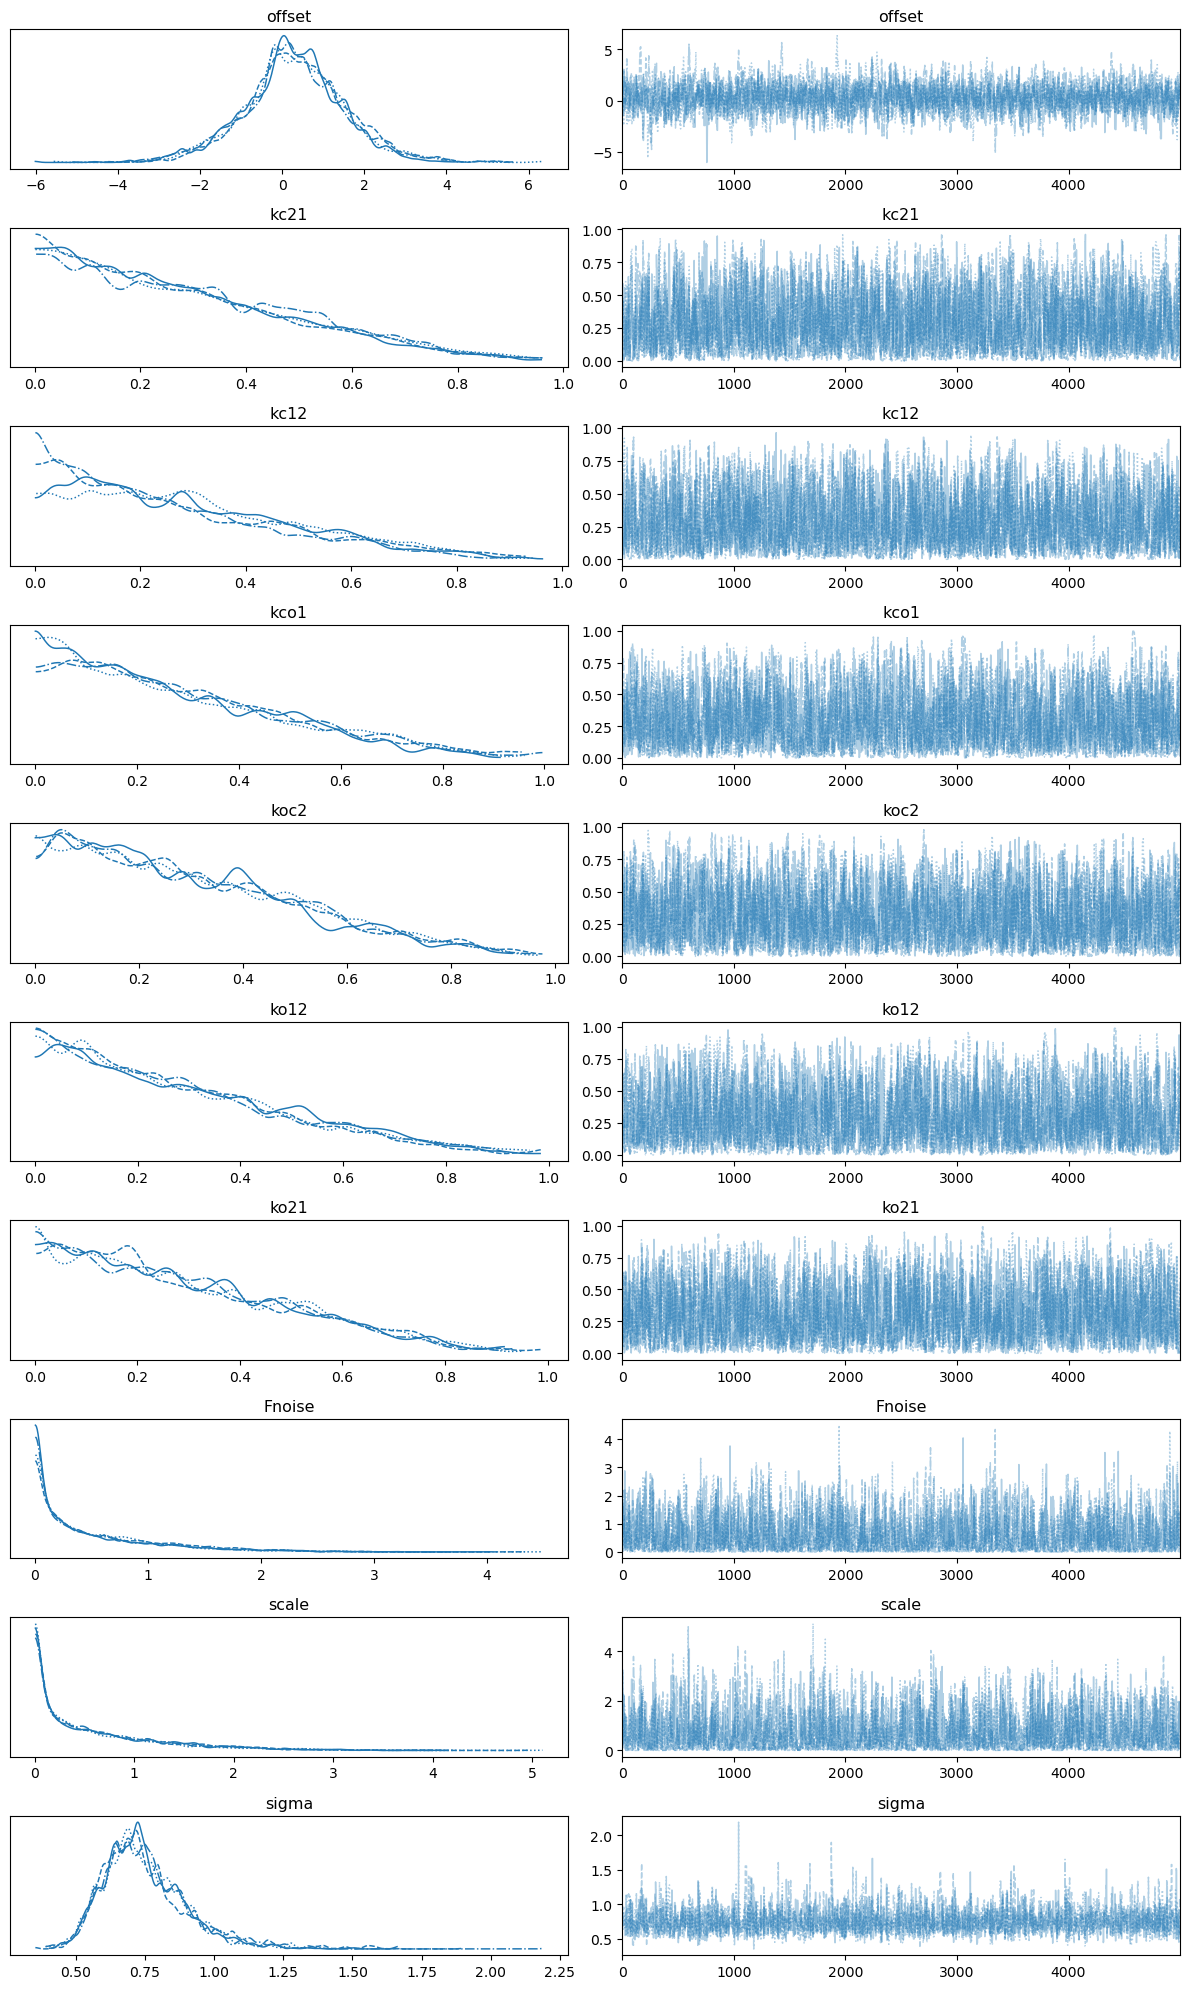

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
kc12    0.280  0.208   0.000    0.658      0.005    0.004    1332.0    1368.0   
kc21    0.288  0.212   0.000    0.672      0.005    0.004    1383.0    1604.0   
Fnoise  0.525  0.573   0.000    1.613      0.014    0.010     920.0     911.0   
scale   0.611  0.670   0.000    1.909      0.017    0.012     694.0     462.0   
offset  0.300  1.240  -2.070    2.706      0.030    0.021    1789.0    2477.0   
kco1    0.285  0.213   0.000    0.677      0.006    0.004    1305.0    1587.0   
koc2    0.299  0.214   0.000    0.686      0.005    0.004    1419.0    1732.0   
ko12    0.284  0.215   0.000    0.676      0.006    0.004    1030.0    1153.0   
ko21    0.294  0.213   0.000    0.674      0.005    0.004    1381.0    1263.0   
sigma   0.749  0.157   0.503    1.048      0.003    0.002    3022.0    2660.0   

        r_hat  
kc12     1.01  
kc21     1.00  
Fnoise   1.00  
scale    1.00  
offset   1.00  
kco1     1.0

In [23]:
# Plot the results
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Print the summary of the posterior
print(az.summary(trace, var_names=["kc12", "kc21", "Fnoise", "scale", "offset", "kco1", "koc2", "ko12", "ko21", "sigma"]))

offset    0.3
Name: mean, dtype: float64
0.3


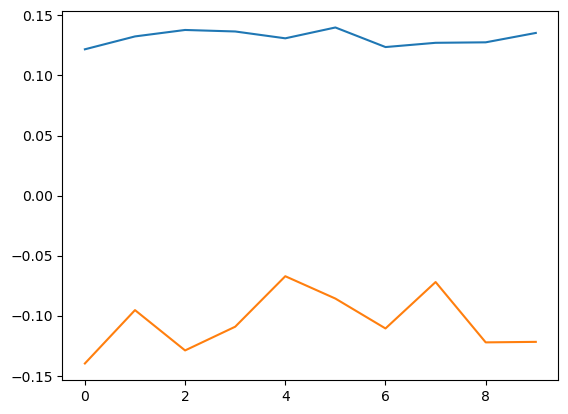

In [24]:
print(az.summary(trace, var_names=["offset"])["mean"])
toffset = az.summary(trace, var_names=["offset"])["mean"].item()
print(toffset)
with model:
    pred_eval = predicted.eval({
        kc12: az.summary(trace, var_names=["kc12"])["mean"].item(),
        kc21: az.summary(trace, var_names=["kc21"])["mean"].item(),
        Fnoise: az.summary(trace, var_names=["Fnoise"])["mean"].item(),
        scale: az.summary(trace, var_names=["scale"])["mean"].item(),
        offset: az.summary(trace, var_names=["offset"])["mean"].item(),
        kco1: az.summary(trace, var_names=["kco1"])["mean"].item(),
        koc2: az.summary(trace, var_names=["koc2"])["mean"].item(),
        ko12: az.summary(trace, var_names=["ko12"])["mean"].item(),
        ko21: az.summary(trace, var_names=["ko21"])["mean"].item(),
        sigma: 0
    })

plt.plot(pred_eval)




In [25]:
kc12= az.summary(trace, var_names=["kc12"])["mean"].item()
kc21= az.summary(trace, var_names=["kc21"])["mean"].item()
Fnoise= az.summary(trace, var_names=["Fnoise"])["mean"].item()
scale= az.summary(trace, var_names=["scale"])["mean"].item()
offset= az.summary(trace, var_names=["offset"])["mean"].item()
kco1= az.summary(trace, var_names=["kco1"])["mean"].item()
koc2= az.summary(trace, var_names=["koc2"])["mean"].item()
ko12= az.summary(trace, var_names=["ko12"])["mean"].item()
ko21= az.summary(trace, var_names=["ko21"])["mean"].item()


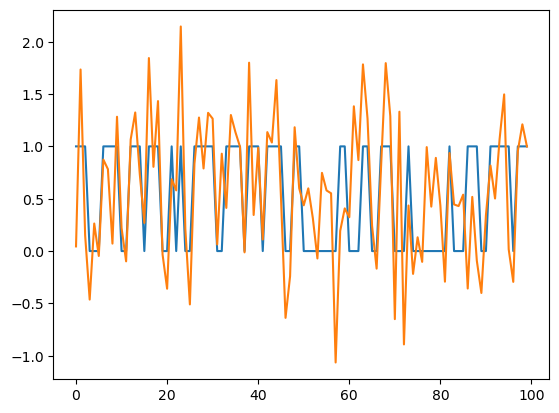

In [26]:
params = [kc12, kc21, Fnoise, scale, offset,  kco1, koc2, ko12, ko21]
channels = sim_channel(params, 100, 1)
plt.plot(channels)